<a href="https://colab.research.google.com/github/tomdct/BlogColabScripts/blob/main/SirenImageFitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image fitting with a Siren**

---

We investigate fitting an image with a Siren. The original Siren project page can be found [here](https://www.vincentsitzmann.com/siren/), and our code has been partially adapted from theirs. We recreate a few of the original Siren experiments, and run through a few of our own. My own blog page, written to accompany this code, can be found [here](https://sites.google.com/view/deeplearningblog/home/sirens/image-fitting-with-a-siren).

(**N.B.** You are better off runing the code on this page with the GPU enabled, which you can find under `Runtime > Change runtime type > Hardware accelerator`, although the CPU does okay with small images and small amounts of training.)

## **Preliminary business**


In [1]:
#@title We start by making all of the imports that we will need.

import os
import numpy as np
import matplotlib.pyplot as plt
import time
import requests
from PIL import Image
from io import BytesIO

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize

In [2]:
#@title Creating a dataset from an image.

# We need to be able to create a dataset in order to feed the pixel color
# data into the training process for our neural networks. We do this in three
# steps:
#
#     1. Convert an image into a tensor.
#
#     2. Create a list of pixel coordinates.
#
#     3. Construct the dataset, which returns the
#        list of coordinates and corresponding pixel values.
#
# The dataset is designed to work with a batch size of 1. In other words,
# in each training loop the neural network sees all of the pixel data exactly
# once and tries to fit itself to it as well as possible.

def image_to_tensor(img):

    # Converts an image to a tensor where RGB values are rescaled
    # to lie in the interval [-1, 1].

    transform = Compose([
        ToTensor(),
        Normalize(torch.Tensor([0.5]),torch.Tensor([0.5]))
    ])

    return transform(img)


def create_grid(grid_steps, bounds=None):

    # Given the input
    #
    #    grid_steps = (a_1,a_2,...,a_n)
    #
    # this returns an list of coordinates for an n-dimensional grid
    # with a_i steps in the ith dimension.
    #
    # If bounds = None then the bounds in each dimension are [-1,1].

    grid_dim = len(grid_steps)

    if bounds == None:
        bounds = [ [-1,1] for i in range(grid_dim)]

    tensors = tuple( [ torch.linspace(bounds[i][0],
                                      bounds[i][1],
                                      steps=grid_steps[i]
                                      ) for i in range(grid_dim) ] )

    my_grid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    return my_grid.reshape(-1, grid_dim)


class ImageFitter(Dataset):

    # This dataset is only designed to be called once, and returns all
    # coordinates and the corresponding pixel values.

    def __init__(self, img):
        super().__init__()
        img_tensor = image_to_tensor(img)
        self.pixels = img_tensor.permute(1, 2, 0).view(-1, no_of_channels)
        self.coords = create_grid((img.height, img.width))

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [3]:
#@title Define the class of a Siren neural network.

# We now define a Siren, which is made up of sin layers. This
# part of the code is adapted from the original Siren project
# referenced above.

class SineLayer(nn.Module):

    # Notes from the original code:
    #
    #   If is_first=True, omega_0 is a frequency factor which simply multiplies
    #   the activations before the nonlinearity. Different signals may require
    #   different omega_0 in the first layer - this is a hyperparameter.
    #
    #   If is_first=False, then the weights will be divided by omega_0 so as to
    #   keep the magnitude of activations constant, but boost gradients to the
    #   weight matrix.

    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))


class Siren(nn.Module):
    def __init__(self, *layer_sizes, outermost_linear=False, first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.no_of_layers = len(layer_sizes)
        self.net = []

        # First layer
        self.net.append(SineLayer(layer_sizes[0], layer_sizes[1], is_first=True, omega_0=first_omega_0))

        # Hidden layers
        for i in range(1, self.no_of_layers - 2):
            self.net.append(SineLayer(layer_sizes[i], layer_sizes[i+1],
                                          is_first=False, omega_0=hidden_omega_0))

        # Last layer
        if outermost_linear:
            final_linear = nn.Linear( layer_sizes[self.no_of_layers-2], layer_sizes[self.no_of_layers-1] )

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / layer_sizes[self.no_of_layers-1]) / hidden_omega_0,
                                              np.sqrt(6 / layer_sizes[self.no_of_layers-1]) / hidden_omega_0)

            self.net.append(final_linear)

        else:
            self.net.append(SineLayer(layer_sizes[self.no_of_layers-2], layer_sizes[self.no_of_layers-1],
                                          is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        output = self.net(coords)
        return output, coords


In [50]:
#@title Implement a training loop for a given neural network.

# First we have a function for converting tensors back to images.

def tensor_to_image(t, img_height, img_width, no_of_channels):

    # Converts a tensor with values in [-1, 1] back into
    # a numpy array with values in [0, 1] that represents
    # an image.
    #
    # Note: After converting we clip to the range [0, 1],
    #       since some float values can end up being 1.000001
    #       (or -0.000001, or similar).

    t = (t + 1)/2
    t = torch.max( torch.zeros_like(t), torch.min( torch.ones_like(t), t ) )

    return t.cpu().view(img_height, img_width, no_of_channels).detach().numpy()

# Now we define a summary step for our training loop.

def print_summary(step, loss, model_output, original_img):

    fig, ax = plt.subplots(1,2)

    ax[0].imshow( tensor_to_image(model_output, img_height, img_width, no_of_channels) )
    ax[0].set_title(f"After %d steps, loss=%0.6f." % (step, loss))

    ax[1].imshow( tensor_to_image(original_img, img_height, img_width, no_of_channels) )
    ax[1].set_title(f"Original image")

    plt.show()

# Now implement the training loop for a given model, optimiser and dataloader.

def run_training_loop(model, optim, dataloader, total_steps, steps_til_summary):

    model_input, original_img = next(iter(dataloader))

    if torch.cuda.is_available():
        model_input, original_img = model_input.cuda(), original_img.cuda()

    for step in range(total_steps+1):
        model_output, coords = model(model_input)
        loss = ((model_output - original_img)**2).mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

        if not step % steps_til_summary:
            print_summary(step, loss, model_output, original_img)

## **Experiment 1: train a SIREN to fit the image.**

Now we are ready to do some basic experiments with our Sirens. We start with a simple exercise of training a Siren to fit a given image.

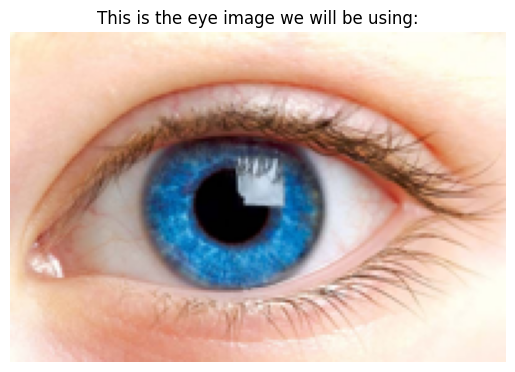

In [59]:
#@title First we load our image.

# Loading the image from a url.

img_url = 'https://cdn.britannica.com/79/150179-050-E2707D87/human-eye.jpg'
response = requests.get(img_url)
my_img = Image.open(BytesIO(response.content))

# We reduce everything down by a scale factor of 4, to
# speed up the experiments. To use the original image
# set scale_factor = 1

scale_factor = 4
my_img = my_img.resize([my_img.width // scale_factor, my_img.height // scale_factor])

# Collect height, width and the number of channels (in this case 3, for RGB)

img_width, img_height = my_img.size[0], my_img.size[1]
img_size = (img_height, img_width)
no_of_channels = len(my_img.getbands())

# Now show the eye image.

fig,ax = plt.subplots(1,1)

ax.imshow(my_img)
ax.set_title('This is the eye image we will be using:')
ax.axis('off')

plt.show()

In [60]:
#@title Next we define the Siren we will use.

# We create a dataloader that will supply the data from our image.

my_image_fitter = ImageFitter(my_img)
my_dataloader = DataLoader(my_image_fitter, batch_size=1, pin_memory=True, num_workers=0)

# Now we define a Siren with
#     - one input layer of size 2 (for the 2 coordinates of a pixel)
#     - three hidden layers of size 256
#     - one final linear layer of size 3 (for the 3 RGB values)
#
# N.B. By default the omega_0 hyperparameters for the layers are set to
#     first_omega_0 = hidden_omega_0 = 30

my_siren = Siren(2, 256, 256, 256, 3, outermost_linear=True)

if torch.cuda.is_available():
    my_siren.cuda()

my_optimiser = torch.optim.Adam(lr=1e-4, params=my_siren.parameters())


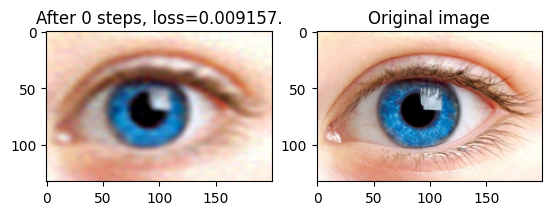

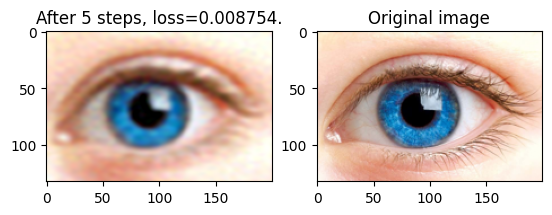

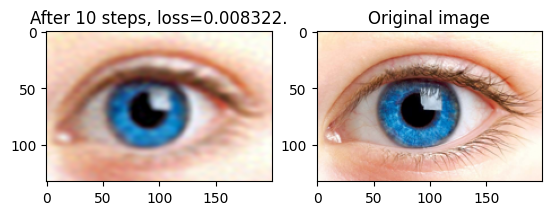

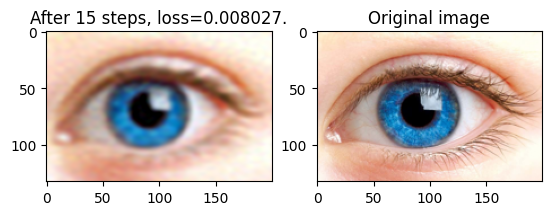

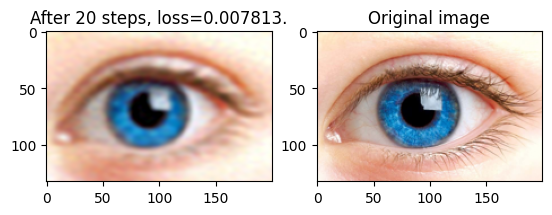

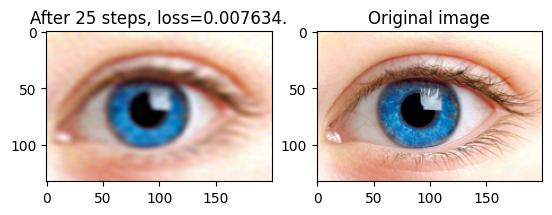

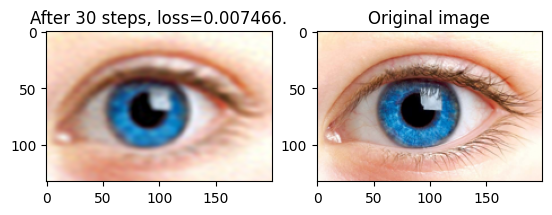

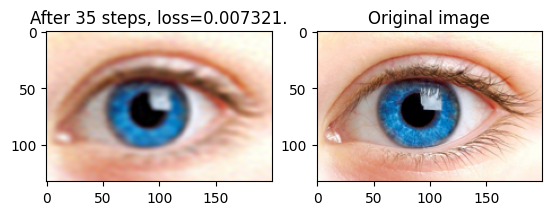

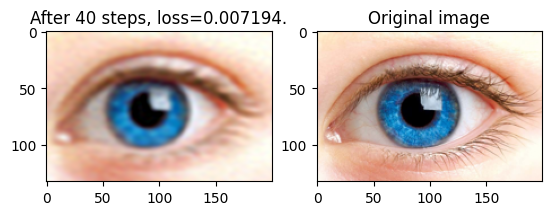

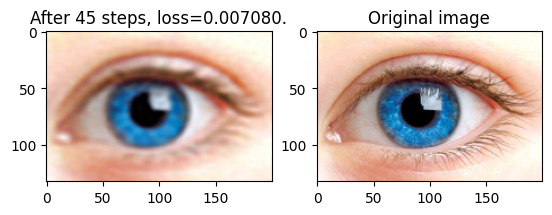

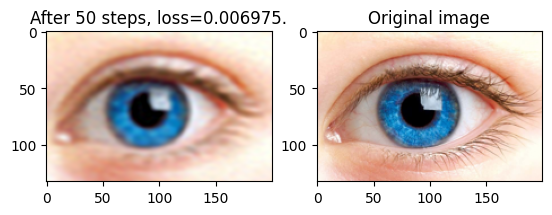

In [69]:
#@title Finally, we train the Siren to fit the image.

# We just start with 50 iterations (but with the GPU enabled we can easily do 5000+).

run_training_loop(my_siren, my_optimiser, my_dataloader, 50, 5)

## **Experiment 2: check for an improvement in resolution.**

Now that we have a trained Siren, we can use it to try and resample the image at a higher resolution. We can go back and try training the Siren some more if we want to improve the resolution even more.

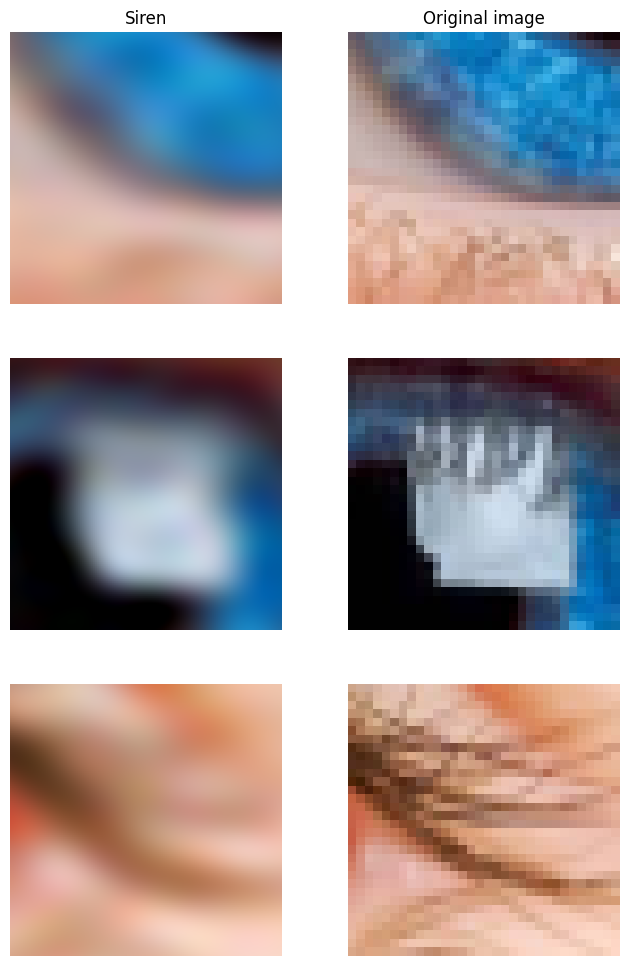

In [70]:
#@title Check for an improvement in resolution in three close-up patches.

# We pick out three close-up patches which we will use to test the
# resolution capabilities of our siren. These patches are 128*128
# in the original image, but recall that we have rescaled the
# image by dividing by scale_factor.

top_left_pixels = [[230, 338], [336, 174], [630, 200]]
patch_size = 128 // scale_factor

# We will use the Siren to resample at four times the resolution.

with torch.no_grad():

    fig,ax = plt.subplots(3,2, figsize=(8,12))

    for i in range(3):
        a, b = top_left_pixels[i][0] // scale_factor, top_left_pixels[i][1] // scale_factor
        zoom_region = create_grid( (4*patch_size, 4*patch_size),
                                    bounds = [ [ 2*b/img_height - 1,
                                                 2*(b + patch_size)/img_height - 1],
                                               [ 2*a/img_width - 1,
                                                 2*(a + patch_size)/img_width - 1]
                                             ]
                                 )

        if torch.cuda.is_available():
            zoom_region = zoom_region.cuda()

        model_output, _ = my_siren(zoom_region)
        ax[i,0].axis('off')
        ax[i,1].axis('off')
        ax[i,0].imshow( tensor_to_image(model_output, 4*patch_size, 4*patch_size, 3) )
        ax[i,1].imshow( my_img.crop((a, b, a + patch_size, b + patch_size)) )
    ax[0,0].set_title(f"Siren")
    ax[0,1].set_title(f"Original image")

    fig.show()



## **Experiment 3: comparision with other types of activation functions.**

We now implement simple ReLU and sigmoid networks with identical layers, and see the difference in how quickly the corresponding network can learn the image.

In [71]:
#@title We define some simple ReLU and Sigmoid networks

# ReLU layers and ReLU networks

class ReLULayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, input):
        return torch.relu(self.linear(input))

class ReLUNetwork(nn.Module):
    def __init__(self, *layer_sizes, outermost_linear=False):
        super().__init__()

        self.no_of_layers = len(layer_sizes)
        self.net = []

        # First and hidden layers
        for i in range(0, self.no_of_layers - 2):
            self.net.append(ReLULayer(layer_sizes[i], layer_sizes[i+1]))

        # Last layer
        if outermost_linear:
            final_linear = nn.Linear( layer_sizes[self.no_of_layers-2], layer_sizes[self.no_of_layers-1] )
            self.net.append(final_linear)
        else:
            self.net.append(ReLULayer(layer_sizes[self.no_of_layers-2], layer_sizes[self.no_of_layers-1]))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

# Sigmoid layers and Sigmoid networks

class SigmoidLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, input):
        return torch.sigmoid(self.linear(input))

class SigmoidNetwork(nn.Module):
    def __init__(self, *layer_sizes, outermost_linear=False):
        super().__init__()

        self.no_of_layers = len(layer_sizes)
        self.net = []

        # First and hidden layers
        for i in range(0, self.no_of_layers - 2):
            self.net.append(SigmoidLayer(layer_sizes[i], layer_sizes[i+1]))

        # Last layer
        if outermost_linear:
            final_linear = nn.Linear( layer_sizes[self.no_of_layers-2], layer_sizes[self.no_of_layers-1] )
            self.net.append(final_linear)
        else:
            self.net.append(SigmoidLayer(layer_sizes[self.no_of_layers-2], layer_sizes[self.no_of_layers-1]))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

In [90]:
#@title A modified training loop for comparisions

# We slightly tweak our training loop to allow for training three
# different models on the same image simultaneously.

# Comparison summary for the training loop.

def print_comparison_summary(step, model_names, model_output):

    fig, ax = plt.subplots(1,4)

    for i in range(3):
        ax[i].axis('off')
        ax[i].imshow( tensor_to_image(model_output[i], img_height, img_width, no_of_channels) )
        ax[i].set_title(model_names[i])

    ax[3].axis('off')
    ax[3].imshow(my_img)
    ax[3].set_title(f"Original image")

    plt.show()

# Now implement the training loop for a given model, optimiser and dataloader.

def run_comparison_training_loop(model_names, models, optims, dataloader, total_steps, steps_til_summary):

    model_input, original_img = next(iter(dataloader))

    if torch.cuda.is_available():
        model_input, original_img = model_input.cuda(), original_img.cuda()

    for step in range(total_steps+1):
        model_outputs = []
        losses = []

        for i in range(3):
            model = models[i]
            optim = optims[i]

            model_output, coords = model(model_input)
            model_outputs.append(model_output)

            loss = ((model_output - original_img)**2).mean()
            losses.append(loss)

            optim.zero_grad()
            loss.backward()
            optim.step()

        if not step % steps_til_summary:
            print(f"After %d steps: %s loss = %0.6f, %s loss = %0.6f and %s loss = %0.6f." % (step,
                                                                                              model_names[0], losses[0],
                                                                                              model_names[1], losses[1],
                                                                                              model_names[2], losses[2]))
            print_comparison_summary(step, model_names, model_outputs)

After 0 steps: Siren loss = 0.515195, ReLU loss = 0.418925 and Sigmoid loss = 0.557949.


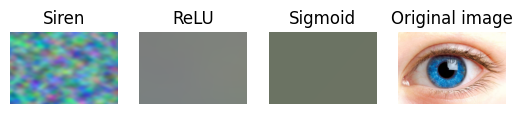

After 10 steps: Siren loss = 0.050772, ReLU loss = 0.343416 and Sigmoid loss = 0.326687.


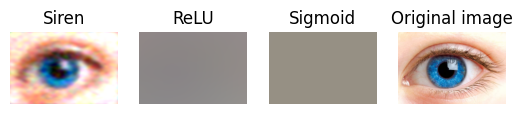

After 20 steps: Siren loss = 0.018991, ReLU loss = 0.280386 and Sigmoid loss = 0.250662.


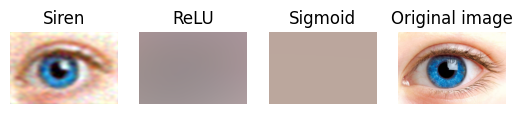

KeyboardInterrupt: ignored

In [91]:
#@title A comparison of different models

# Define the three different models with their optimisers

my_siren   = Siren(2, 256, 256, 256, 3, outermost_linear=True, first_omega_0=30, hidden_omega_0=30)
my_relu    = ReLUNetwork(2, 256, 256, 256, 3, outermost_linear=True)
my_sigmoid = SigmoidNetwork(2, 256, 256, 256, 3, outermost_linear=True)

if torch.cuda.is_available():
    my_siren.cuda()
    my_relu.cuda()
    my_sigmoid.cuda()

my_models = [ my_siren, my_relu, my_sigmoid ]

optim_siren   = torch.optim.Adam(lr=1e-4, params=my_siren.parameters())
optim_relu    = torch.optim.Adam(lr=1e-4, params=my_relu.parameters())
optim_sigmoid = torch.optim.Adam(lr=1e-4, params=my_sigmoid.parameters())

my_optims = [ optim_siren, optim_relu, optim_sigmoid ]

# Implement the training loop.

run_comparison_training_loop( ['Siren','ReLU','Sigmoid'], my_models, my_optims, my_dataloader, 500, 10 )

## **Experiment 4: messing around with Sirens.**

We now consider playing around with all of the hyperparameters and the structure of the network. (Partly in order to test how well the Siren learns after tweaking the hyperparameters, and partly because we can get some fun and interesting pictures!)

After 0 steps: Siren A loss = 0.464413, Siren B loss = 0.970354 and Siren C loss = 0.367688.


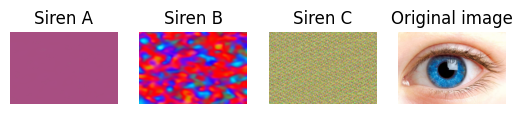

After 10 steps: Siren A loss = 0.396963, Siren B loss = 0.712710 and Siren C loss = 0.267667.


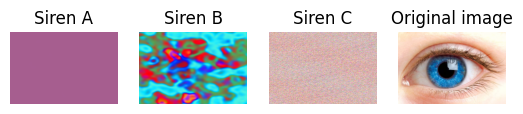

After 20 steps: Siren A loss = 0.356633, Siren B loss = 0.545091 and Siren C loss = 0.247019.


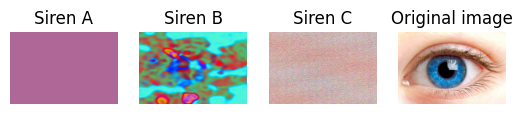

After 30 steps: Siren A loss = 0.326192, Siren B loss = 0.453075 and Siren C loss = 0.222411.


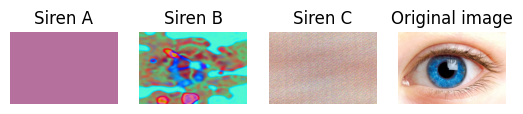

After 40 steps: Siren A loss = 0.304136, Siren B loss = 0.388400 and Siren C loss = 0.197157.


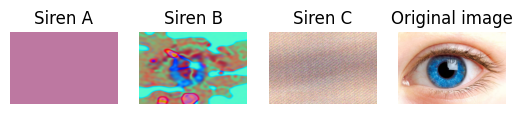

After 50 steps: Siren A loss = 0.288039, Siren B loss = 0.339666 and Siren C loss = 0.188276.


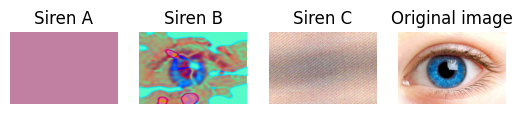

After 60 steps: Siren A loss = 0.276165, Siren B loss = 0.304656 and Siren C loss = 0.179263.


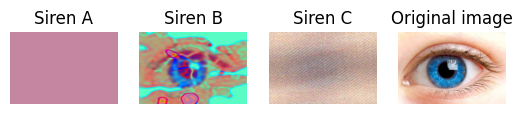

After 70 steps: Siren A loss = 0.267433, Siren B loss = 0.270481 and Siren C loss = 0.172606.


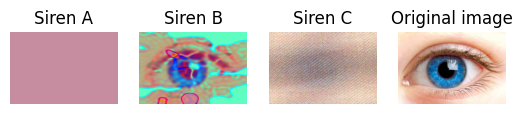

After 80 steps: Siren A loss = 0.261060, Siren B loss = 0.244421 and Siren C loss = 0.167675.


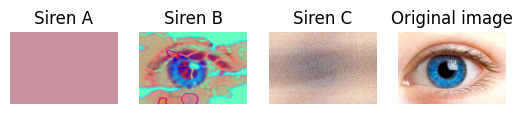

After 90 steps: Siren A loss = 0.256476, Siren B loss = 0.223220 and Siren C loss = 0.163831.


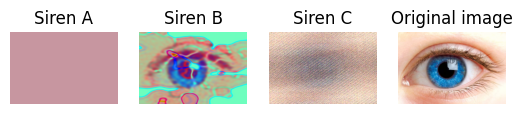

After 100 steps: Siren A loss = 0.253263, Siren B loss = 0.199888 and Siren C loss = 0.160559.


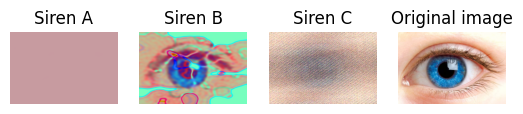

After 110 steps: Siren A loss = 0.250945, Siren B loss = 0.181117 and Siren C loss = 0.157602.


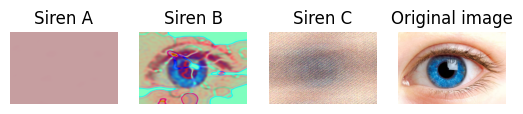

After 120 steps: Siren A loss = 0.244318, Siren B loss = 0.164413 and Siren C loss = 0.154805.


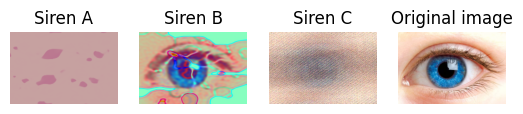

After 130 steps: Siren A loss = 0.234399, Siren B loss = 0.152105 and Siren C loss = 0.152080.


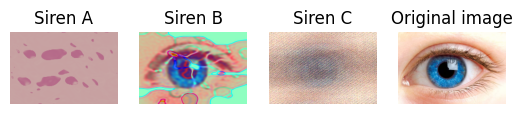

After 140 steps: Siren A loss = 0.221405, Siren B loss = 0.139500 and Siren C loss = 0.149375.


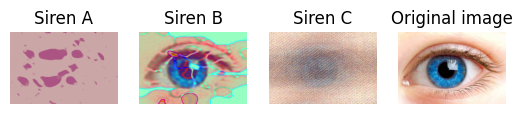

After 150 steps: Siren A loss = 0.210119, Siren B loss = 0.127305 and Siren C loss = 0.146652.


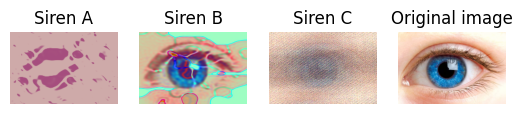

After 160 steps: Siren A loss = 0.203191, Siren B loss = 0.119154 and Siren C loss = 0.143887.


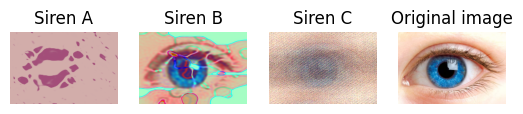

After 170 steps: Siren A loss = 0.199237, Siren B loss = 0.109055 and Siren C loss = 0.141062.


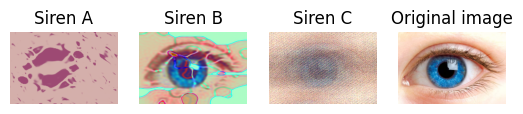

After 180 steps: Siren A loss = 0.171961, Siren B loss = 0.101795 and Siren C loss = 0.138165.


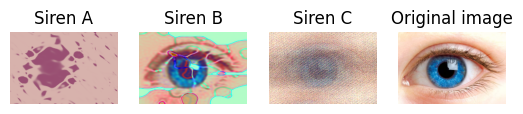

After 190 steps: Siren A loss = 0.161831, Siren B loss = 0.094473 and Siren C loss = 0.135191.


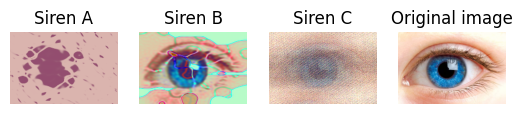

After 200 steps: Siren A loss = 0.157029, Siren B loss = 0.088606 and Siren C loss = 0.132136.


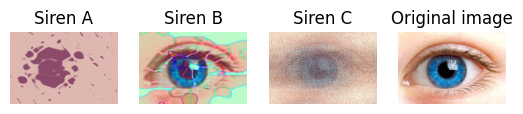

After 210 steps: Siren A loss = 0.148799, Siren B loss = 0.083015 and Siren C loss = 0.128998.


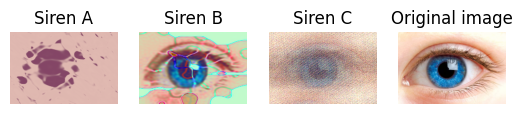

After 220 steps: Siren A loss = 0.147289, Siren B loss = 0.077921 and Siren C loss = 0.125775.


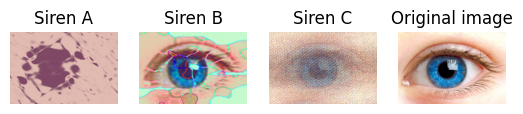

After 230 steps: Siren A loss = 0.137898, Siren B loss = 0.073885 and Siren C loss = 0.122469.


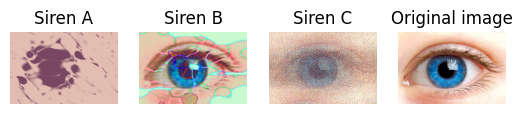

After 240 steps: Siren A loss = 0.133052, Siren B loss = 0.070210 and Siren C loss = 0.119081.


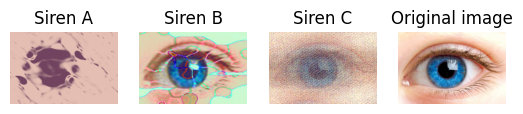

After 250 steps: Siren A loss = 0.129462, Siren B loss = 0.068480 and Siren C loss = 0.115612.


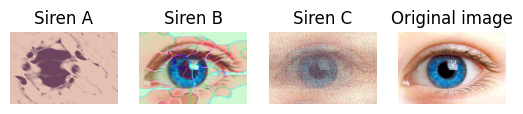

After 260 steps: Siren A loss = 0.126619, Siren B loss = 0.066331 and Siren C loss = 0.112070.


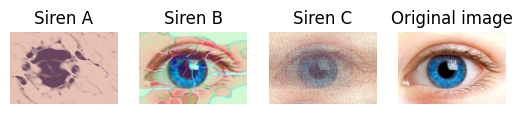

After 270 steps: Siren A loss = 0.125167, Siren B loss = 0.060986 and Siren C loss = 0.108461.


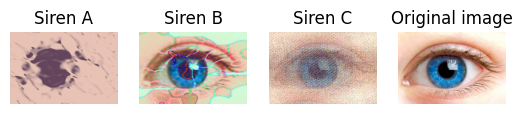

After 280 steps: Siren A loss = 0.120918, Siren B loss = 0.060161 and Siren C loss = 0.104793.


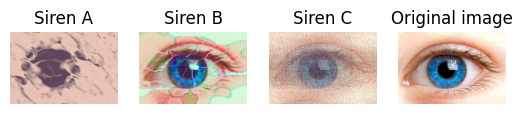

After 290 steps: Siren A loss = 0.121392, Siren B loss = 0.057584 and Siren C loss = 0.101079.


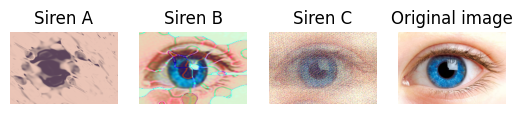

After 300 steps: Siren A loss = 0.121500, Siren B loss = 0.053693 and Siren C loss = 0.097329.


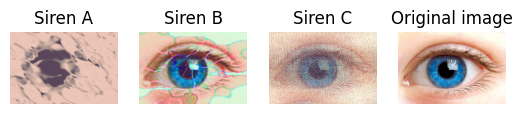

After 310 steps: Siren A loss = 0.115499, Siren B loss = 0.052052 and Siren C loss = 0.093566.


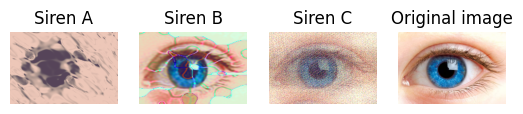

After 320 steps: Siren A loss = 0.112666, Siren B loss = 0.049988 and Siren C loss = 0.089814.


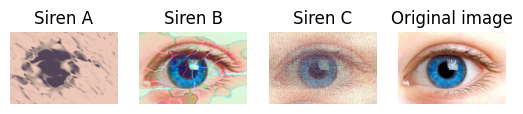

After 330 steps: Siren A loss = 0.116207, Siren B loss = 0.049549 and Siren C loss = 0.086087.


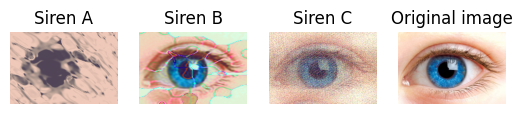

After 340 steps: Siren A loss = 0.111386, Siren B loss = 0.046847 and Siren C loss = 0.082409.


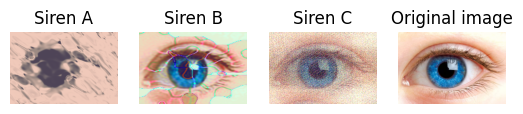

After 350 steps: Siren A loss = 0.108353, Siren B loss = 0.048593 and Siren C loss = 0.078799.


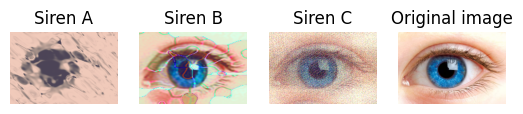

After 360 steps: Siren A loss = 0.106741, Siren B loss = 0.046019 and Siren C loss = 0.075268.


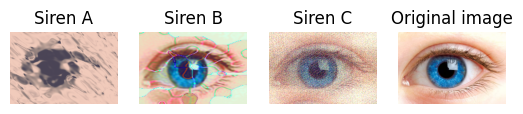

After 370 steps: Siren A loss = 0.110611, Siren B loss = 0.043595 and Siren C loss = 0.071825.


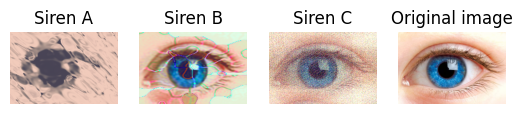

After 380 steps: Siren A loss = 0.106084, Siren B loss = 0.042306 and Siren C loss = 0.068469.


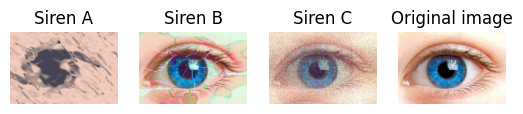

After 390 steps: Siren A loss = 0.103167, Siren B loss = 0.041166 and Siren C loss = 0.065211.


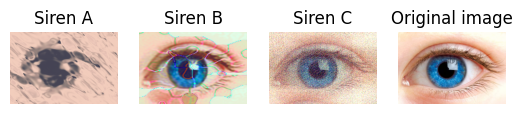

After 400 steps: Siren A loss = 0.111158, Siren B loss = 0.040486 and Siren C loss = 0.062057.


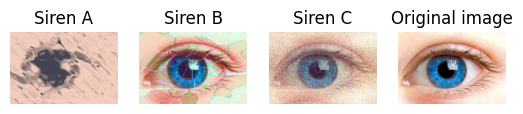

After 410 steps: Siren A loss = 0.103320, Siren B loss = 0.038827 and Siren C loss = 0.059012.


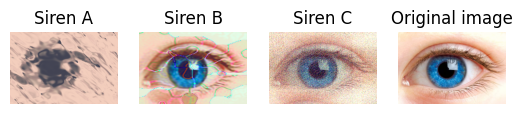

After 420 steps: Siren A loss = 0.101404, Siren B loss = 0.040439 and Siren C loss = 0.056095.


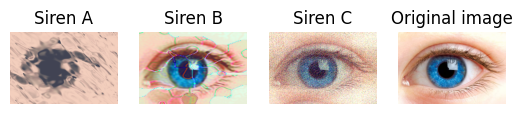

After 430 steps: Siren A loss = 0.102767, Siren B loss = 0.037836 and Siren C loss = 0.053285.


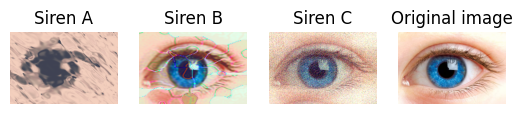

After 440 steps: Siren A loss = 0.099642, Siren B loss = 0.036114 and Siren C loss = 0.050616.


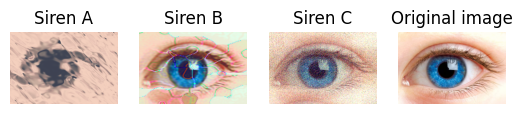

After 450 steps: Siren A loss = 0.109947, Siren B loss = 0.035338 and Siren C loss = 0.048078.


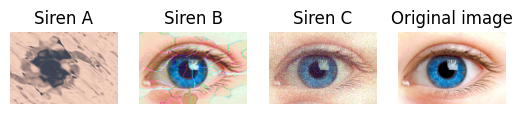

After 460 steps: Siren A loss = 0.106010, Siren B loss = 0.034613 and Siren C loss = 0.045675.


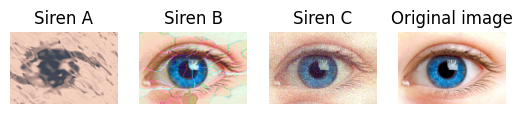

After 470 steps: Siren A loss = 0.099591, Siren B loss = 0.034199 and Siren C loss = 0.043405.


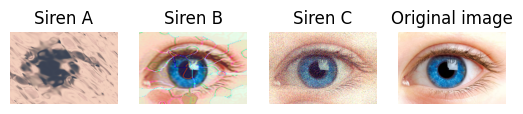

After 480 steps: Siren A loss = 0.097753, Siren B loss = 0.034810 and Siren C loss = 0.041264.


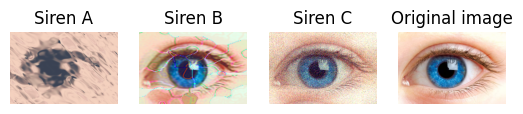

After 490 steps: Siren A loss = 0.096286, Siren B loss = 0.033927 and Siren C loss = 0.039237.


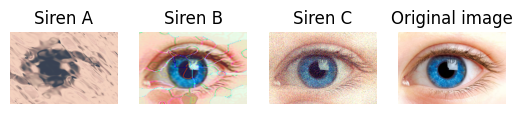

After 500 steps: Siren A loss = 0.095791, Siren B loss = 0.033843 and Siren C loss = 0.037330.


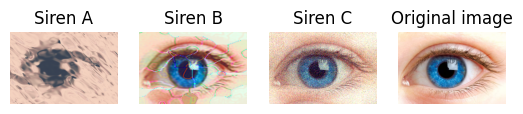

In [97]:
#@title Three modified Sirens

# We define three Sirens with the following properties, and then feed them into
# our comparison training loop.
#
#    A: A deep narrow network with a training rate of 1e-3.
#
#    B: The last hidden layer is small and the outer layer is a sin layer.
#
#    C: The first hidden layer is smaller and first_omega_0 is large.
#
# Of course, feel free to try your own experiments!

siren_a = Siren(2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, outermost_linear=True)

siren_b = Siren(2, 256, 256, 256, 3, 3, outermost_linear=False)

siren_c = Siren(2, 16, 256, 256, 3, outermost_linear=True, first_omega_0=300)

if torch.cuda.is_available():
    siren_a.cuda()
    siren_b.cuda()
    siren_c.cuda()

my_models = [ siren_a, siren_b, siren_c ]

optim_a = torch.optim.Adam(lr=1e-3, params=siren_a.parameters())
optim_b = torch.optim.Adam(lr=1e-4, params=siren_b.parameters())
optim_c = torch.optim.Adam(lr=1e-4, params=siren_c.parameters())

my_optims = [ optim_a, optim_b, optim_c ]

# Implement the training loop.

run_comparison_training_loop(['Siren A', 'Siren B', 'Siren C'], my_models, my_optims, my_dataloader, 500, 10)